Description:
- Reads a CSV with columns: SMILES, Sequence, Value, Split
- Computes Morgan fingerprint (2048 bits) for SMILES
- Computes Amino Acid Composition (20-d) for protein Sequence
- Concatenates features and trains a simple RandomForestRegressor baseline
- Evaluates on provided Test/Validation splits and prints metrics

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
import numpy as np

In [2]:
def smile_to_fp(smile ,radius , nBits):
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits= nBits)
    arr = np.zeros((1,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def aa_composition(seq):
    seq='' if pd.isna(seq) else str(seq)
    l=len(seq)
    counts = np.zeros((20,), dtype=np.float32)
    if l==0:
        return counts
    seq=seq.upper()
    AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
    mapping = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
    for s in seq:
        if s in mapping:
            counts[mapping[s]] += 1.0
    counts /= l # normalize by length
    return counts

def flatten_features(row):
    return  np.concatenate([row['SMILES_FP'].astype(np.float32), row['SEQ_AC'].astype(np.float32)])

def build_feature_matrix(df, fp_bits=2048, show_progress=False):
    X = []
    for _, r in df.iterrows():
        X.append(flatten_features(r, fp_bits=fp_bits))
    X = np.vstack(X)
    return X

In [17]:
ds=pd.read_csv('../data/BindingDB.csv')
ds.sample(2)

,Identifier,Uniprot ID,SMILES,Sequence,Value,Split
668735,668869,P30542,Cc1ocnc1Cn1nc2c(C3=CC(C)=[N++]([O-])C(C)=C3)c(...,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,10.231228,Val
466731,466743,P00533,COc1ccccc1C(=O)NCc1ccc(cc1)-c1nn([C@@H]2CCc3cc...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8.538814,Train


In [18]:
train_set=ds[ds["Split"]=="Train"]
valid_set=ds[ds["Split"]=="Val"]
print("Dataset shape:", ds.shape)
print("unique targets:", ds['Sequence'].nunique())
print("unique SMILES:", ds['SMILES'].nunique())
print("Binding affinity range (pKi):", ds['Value'].min(), "to", ds['Value'].max())
print("train samples size:", train_set.shape[0])
print("train samples per target:")
print(train_set.groupby('Sequence').size().describe())

Dataset shape: (1645667, 6)
unique targets: 8203
unique SMILES: 1037995
Binding affinity range (pKi): -5.456427145044637 to 20.0
train samples size: 1316535
train samples per target:
count     7978.000000
mean       165.020682
std        570.263693
min          1.000000
25%          3.000000
50%         15.000000
75%         71.000000
max      10304.000000
dtype: float64


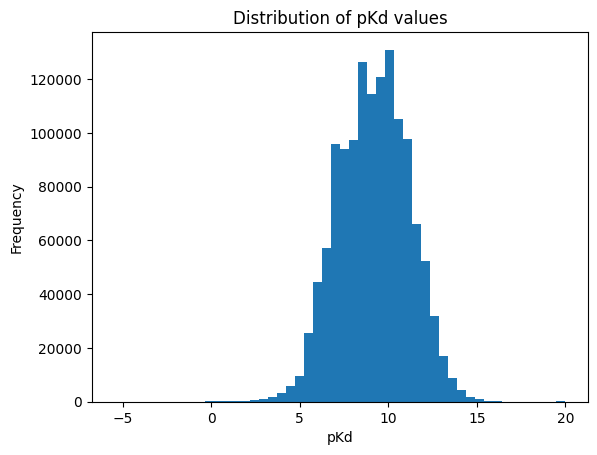

In [9]:
# plot distribution of pKd
import matplotlib.pyplot as plt
plt.hist(train_set['Value'], bins=50)
plt.xlabel('pKd')
plt.ylabel('Frequency')
plt.title('Distribution of pKd values')
plt.show()

In [19]:
train_set=train_set.sample(1000, random_state=42).reset_index(drop=True)  # for faster testing, use a subset of 10,000 samples
train_set["SMILES_FP"] = train_set["SMILES"].apply(lambda x: smile_to_fp(x, radius=2, nBits=1024))
train_set["SEQ_AC"] = train_set["Sequence"].apply(aa_composition)
train_set.dropna(subset=["SMILES_FP", "SEQ_AC"], inplace=True)

[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerator
[13:40:01] DEPRECATION WARNING: please use MorganGenerat

In [20]:
X= train_set.apply(flatten_features, axis=1)
X = np.vstack(X.values)
y = train_set["Value"].astype(float).values

In [23]:
# RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X, y)
y_pred = rf_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Train MSE: {mse:.4f}, R2: {r2:.4f}")

Train MSE: 0.5528, R2: 0.8587


In [24]:
# xgboost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)
xgb_model.fit(X, y)
y_pred_xgb = xgb_model.predict(X)
mse_xgb = mean_squared_error(y, y_pred_xgb)
r2_xgb = r2_score(y, y_pred_xgb)
print(f"XGBoost Train MSE: {mse_xgb:.4f},R2: {r2_xgb:.4f}")  


XGBoost Train MSE: 0.0000,R2: 1.0000


- SHAP
    - Contribution of each feature to each prediction
    - Direction (+ / − effect)
    - Global + local interpretability

c:\Users\hanif\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


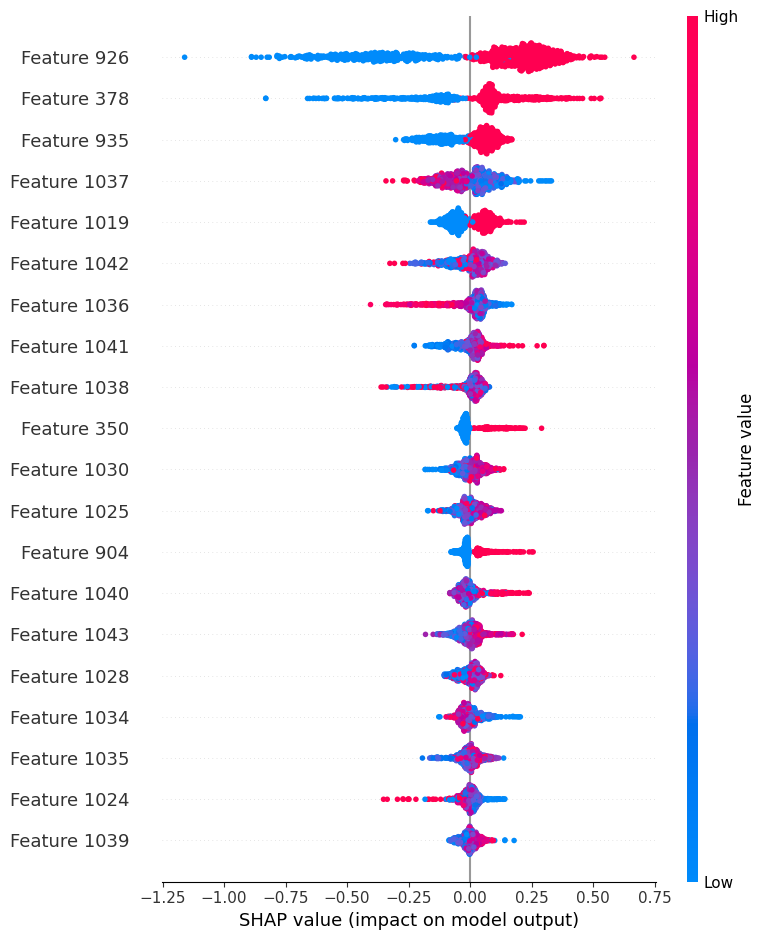

In [29]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)


Interpretation

Red → increases affinity

Blue → decreases affinity

Feature spread → importance

# RF + XGBoost Ensemble with Stacking (Meta-Learner)
- Use RF & XGB as base learners, feed their predictions into a meta-model.
- Meta-model learns when to trust RF vs XGB
- Often beats both standalone models



In [30]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

estimators = [
    ("rf", rf_model),
    ("xgb", xgb_model)
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

stack.fit(X, y)
stack_pred = stack.predict(X)
mse_stack = mean_squared_error(y, stack_pred)
r2_stack= r2_score(y, stack_pred)
print(f"stacking method : {mse_xgb:.4f},R2: {r2_stack:.4f}")  


stacking method : 0.0000,R2: 0.9375
